**This notebook provides a comprehensive workflow for predicting stock prices using LSTM models, including data fetching, preprocessing, model training, prediction, and visualization for multiple stock tickers.**

# Import Libraries and Define StockPredictor Class
This cell imports necessary Python libraries and defines the StockPredictor class for stock price prediction:





* Imports libraries including pandas, numpy, yfinance for data fetching, matplotlib and seaborn for visualization, sklearn for data scaling, and tensorflow.keras for building LSTM models.



* Sets up logging, suppresses warnings, and applies a clean plotting style (seaborn-v0_8-whitegrid).



* Defines the StockPredictor class with methods to:





* Fetch stock data from Yahoo Finance (fetch_data).



* Preprocess data for LSTM modeling (preprocess_data).



* Build and train an LSTM model (build_model).



* Make predictions for past and future stock prices (predict).



* Plot training, actual, predicted, and future stock prices (plot_results).



* Includes a main function to initialize the predictor for tickers (AAPL, GOOG, MSFT, AMZN), fetch data, train models, make predictions, and visualize results.



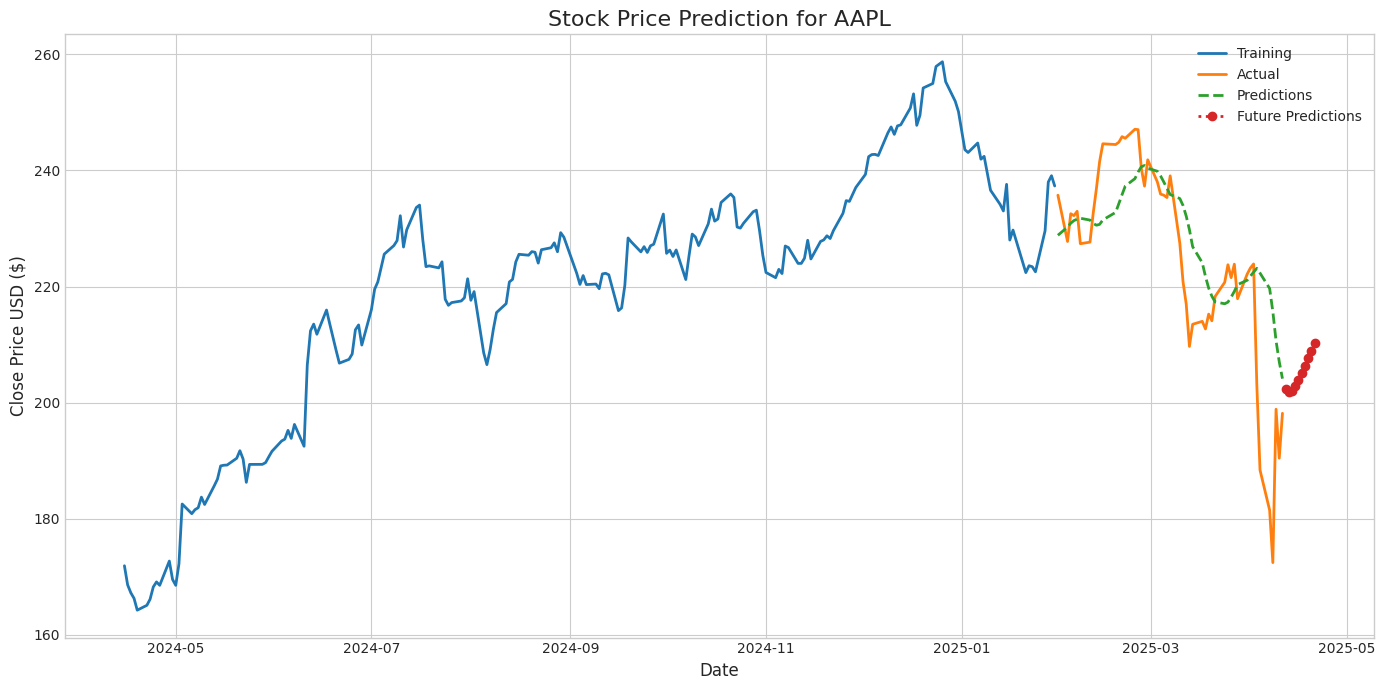


Future Predictions for AAPL:
            Future Predictions
2025-04-12          202.390259
2025-04-13          201.838776
2025-04-14          202.071884
2025-04-15          202.809036
2025-04-16          203.851852
2025-04-17          205.063950
2025-04-18          206.354202
2025-04-19          207.663239
2025-04-20          208.953537
2025-04-21          210.202148


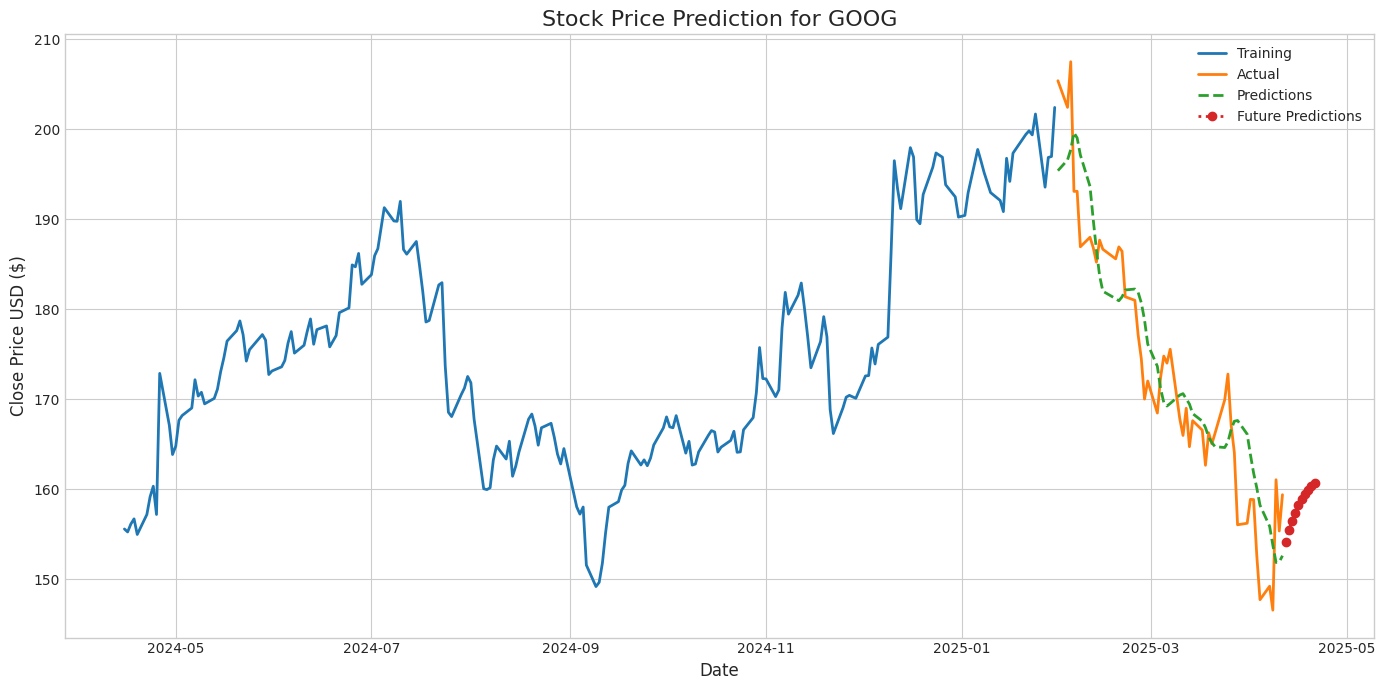


Future Predictions for GOOG:
            Future Predictions
2025-04-12          154.163803
2025-04-13          155.435516
2025-04-14          156.508072
2025-04-15          157.423172
2025-04-16          158.207718
2025-04-17          158.879623
2025-04-18          159.451828
2025-04-19          159.934601
2025-04-20          160.336960
2025-04-21          160.667511


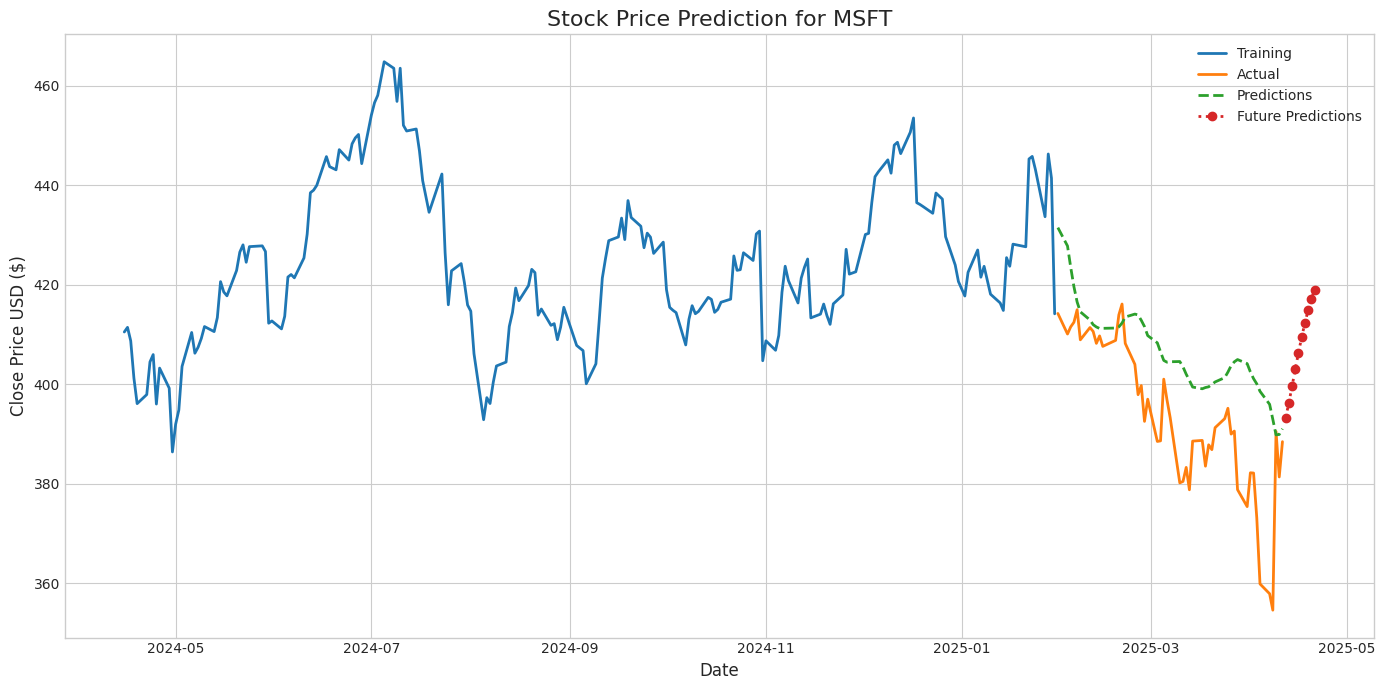


Future Predictions for MSFT:
            Future Predictions
2025-04-12          393.269684
2025-04-13          396.270142
2025-04-14          399.612122
2025-04-15          403.029053
2025-04-16          406.352661
2025-04-17          409.476715
2025-04-18          412.334991
2025-04-19          414.887817
2025-04-20          417.114227
2025-04-21          419.006897


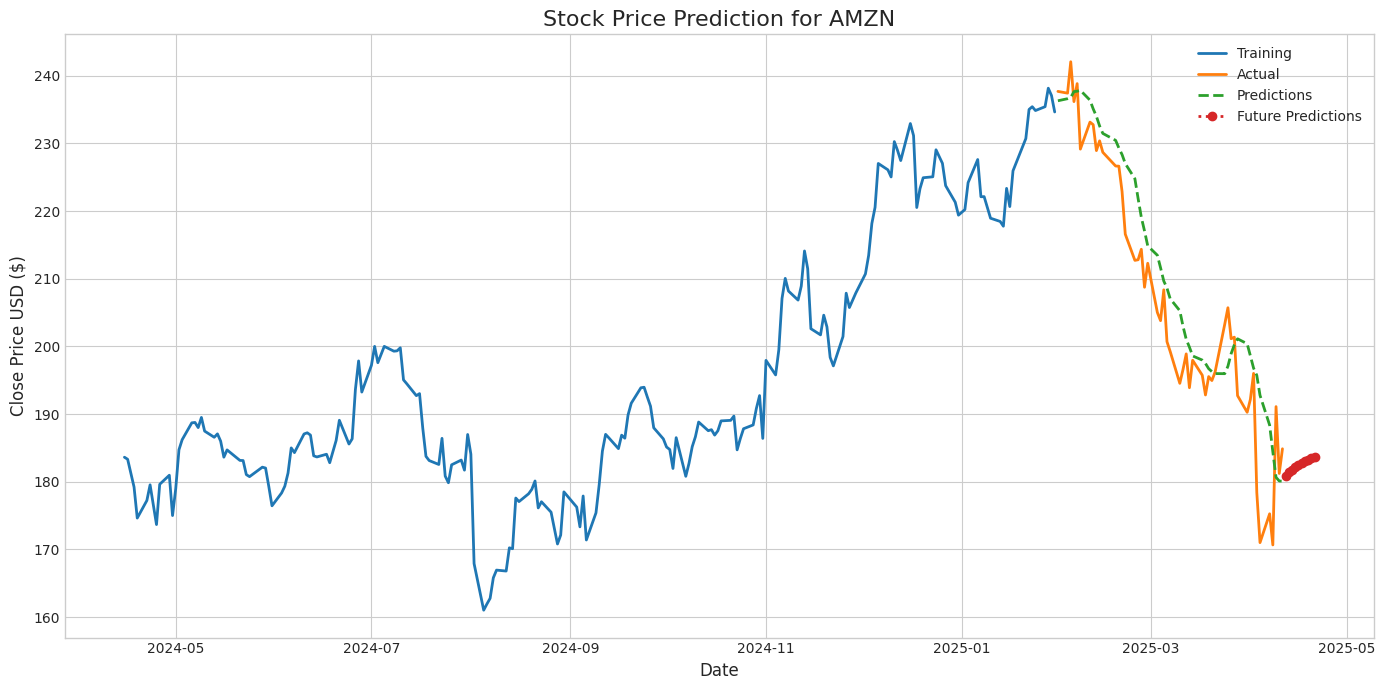


Future Predictions for AMZN:
            Future Predictions
2025-04-12          180.831207
2025-04-13          181.369919
2025-04-14          181.797958
2025-04-15          182.160889
2025-04-16          182.481262
2025-04-17          182.769272
2025-04-18          183.028961
2025-04-19          183.261658
2025-04-20          183.467758
2025-04-21          183.647720


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import logging
from typing import List, Tuple, Optional
import warnings

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid') # Use a visually appealing style
sns.set_style('whitegrid')

class StockPredictor:
    def __init__(self, tickers: List[str], look_back: int = 60):
        self.tickers = tickers
        self.look_back = look_back
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.data = {}
        self.models = {}
        self.training_data_len = 0

    def fetch_data(self, start_date: str = None, end_date: str = None) -> bool:
        """Fetch stock data from Yahoo Finance."""
        try:
            if end_date is None:
                end_date = datetime.now()
            if start_date is None:
                start_date = end_date - timedelta(days=365)

            for ticker in self.tickers:
                logger.info(f"Fetching data for {ticker}")
                df = yf.download(ticker, start=start_date, end=end_date, progress=False)

                if df.empty:
                    logger.error(f"No data retrieved for {ticker}")
                    return False

                # Ensure we have the Close column
                if 'Close' not in df.columns:
                    logger.error(f"Close column not found for {ticker}")
                    return False

                df['company_name'] = ticker
                self.data[ticker] = df
            return True
        except Exception as e:
            logger.error(f"Error fetching data: {str(e)}")
            return False

    def preprocess_data(self, ticker: str) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """Preprocess stock data for LSTM model."""
        try:
            df = self.data[ticker][['Close']].copy()

            # Handle missing values
            df = df.fillna(method='ffill').fillna(method='bfill')

            # Scale the data
            scaled_data = self.scaler.fit_transform(df)

            # Calculate training data length (80% train, 20% test)
            self.training_data_len = int(len(scaled_data) * 0.8)

            # Create training dataset
            X_train, y_train = [], []
            for i in range(self.look_back, self.training_data_len):
                X_train.append(scaled_data[i-self.look_back:i, 0])
                y_train.append(scaled_data[i, 0])

            X_train, y_train = np.array(X_train), np.array(y_train)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

            return X_train, y_train
        except Exception as e:
            logger.error(f"Error preprocessing data for {ticker}: {str(e)}")
            return None

    def build_model(self, ticker: str) -> bool:
        """Build and train LSTM model."""
        try:
            data = self.preprocess_data(ticker)
            if data is None:
                return False

            X_train, y_train = data

            # Build LSTM model
            model = Sequential([
                LSTM(100, return_sequences=True, input_shape=(self.look_back, 1)),
                Dropout(0.2),
                LSTM(50, return_sequences=False),
                Dropout(0.2),
                Dense(25),
                Dense(1)
            ])

            # Compile model
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

            # Train model
            logger.info(f"Training model for {ticker}")
            model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)

            self.models[ticker] = model
            return True
        except Exception as e:
            logger.error(f"Error building model for {ticker}: {str(e)}")
            return False

    def predict(self, ticker: str, days_ahead: int = 10) -> Optional[pd.DataFrame]:
        """Make predictions for the specified ticker."""
        try:
            if ticker not in self.models:
                logger.error(f"No model found for {ticker}")
                return None

            df = self.data[ticker][['Close']].copy()
            scaled_data = self.scaler.transform(df)

            # Prepare test data
            X_test = []
            for i in range(self.training_data_len, len(scaled_data)):
                X_test.append(scaled_data[i-self.look_back:i, 0])

            X_test = np.array(X_test)
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            # Make predictions
            predictions = self.models[ticker].predict(X_test, verbose=0)
            predictions = self.scaler.inverse_transform(predictions)

            # Create result dataframe
            valid = df[self.training_data_len:].copy()
            valid['Predictions'] = predictions

            # Future predictions
            last_sequence = scaled_data[-self.look_back:].reshape((1, self.look_back, 1))
            future_predictions = []

            for _ in range(days_ahead):
                pred = self.models[ticker].predict(last_sequence, verbose=0)
                future_predictions.append(pred[0, 0])
                last_sequence = np.roll(last_sequence, -1)
                last_sequence[0, -1, 0] = pred

            future_predictions = self.scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

            # Create future dates
            last_date = df.index[-1]
            future_dates = [last_date + timedelta(days=x) for x in range(1, days_ahead + 1)]
            future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Future Predictions'])

            return valid, future_df
        except Exception as e:
            logger.error(f"Error making predictions for {ticker}: {str(e)}")
            return None

    def plot_results(self, ticker: str, valid: pd.DataFrame, future_df: pd.DataFrame):
        """Plot the results."""
        try:
            train = self.data[ticker][['Close']][:self.training_data_len]

            plt.figure(figsize=(14, 7))
            plt.title(f'Stock Price Prediction for {ticker}', fontsize=16)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Close Price USD ($)', fontsize=12)

            # Plot training data
            plt.plot(train.index, train['Close'], label='Training', linewidth=2)

            # Plot validation data
            plt.plot(valid.index, valid['Close'], label='Actual', linewidth=2)
            plt.plot(valid.index, valid['Predictions'], label='Predictions', linewidth=2, linestyle='--')

            # Plot future predictions
            plt.plot(future_df.index, future_df['Future Predictions'], label='Future Predictions',
                    linewidth=2, linestyle=':', marker='o')

            plt.legend(fontsize=10)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            logger.error(f"Error plotting results for {ticker}: {str(e)}")

def main():
    # Initialize predictor
    tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
    predictor = StockPredictor(tickers)

    # Fetch data
    if not predictor.fetch_data():
        logger.error("Failed to fetch data. Exiting.")
        return

    # Process each ticker
    for ticker in tickers:
        # Build and train model
        if not predictor.build_model(ticker):
            logger.error(f"Failed to build model for {ticker}. Skipping.")
            continue

        # Make predictions
        result = predictor.predict(ticker)
        if result is None:
            logger.error(f"Failed to make predictions for {ticker}. Skipping.")
            continue

        valid, future_df = result

        # Plot results
        predictor.plot_results(ticker, valid, future_df)

        # Print future predictions
        print(f"\nFuture Predictions for {ticker}:")
        print(future_df)

if __name__ == "__main__":
    main()